In [1]:
#Realizacion actividad finetuning
#Realizado por: Cristian Ibañez Bautista

In [18]:
import os
from zipfile import ZipFile

import torch
from PIL import Image


class ImageClassZipDataset(torch.utils.data.Dataset):

    def __init__(self, zip_path, data_split, class_names, transform=None, target_transform=None, info_encoding='utf8'):
        if not os.path.exists(zip_path):
            raise RuntimeError('%s does not exist' % zip_path)

        self.zip_path = zip_path
        self.data_split = data_split
        self.class_names = class_names
        self.transform = transform
        self.target_transform = target_transform
        self.samples = []

        with ZipFile(self.zip_path, "r") as f:
          for name in f.namelist():
              # Split the path to the image file within the zip archive
              splitted_name = name.split('/')
              # If it is an image, there are at least two parent folders, and the data split name matches,
              # then insert the sample. Each sample is a pair composed of the image file name
              # within the zip archive plus the class name
              if name.lower().endswith(('.png', '.jpg', '.jpeg')) and len(splitted_name)>=3 and splitted_name[-3]==data_split:
                # Open the image file within the zip archive
                img_file = f.open(name)
                # Read the image file and convert it to RGB format
                this_img = Image.open(img_file).convert('RGB')
                # Convert the class name (string) to a class index (from zero to number of classes less 1)
                # Please note that PyTorch does not support class names as strings; thereby class indices must be employed
                class_index = self.class_names.index(splitted_name[-2])
                # Append the sample to the list of samples
                self.samples.append((this_img,class_index,name))
        # Sort the samples by class index and then by image file name
        self.samples.sort(key=lambda x: (x[1],x[2]))


    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        # Extract the image data, the class index, and the image file name
        sample, target, img_filename = self.samples[index]

        if self.transform is not None:
            sample = self.transform(sample)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target


    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Zip Location: {}\n'.format(self.zip_path)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [19]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Print the runtime environment versions
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
from google.colab import drive
drive.mount('/content/drive')


PyTorch Version:  2.6.0+cu124
Torchvision Version:  0.21.0+cu124
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
texlive is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
#Apartado 1 aqui cargamos los datos que vamos a usar

ziparchive_path = '/content/drive/MyDrive/SVHN.zip'

model_name = "squeezenet"

# Aqui definimos las clases que tenemos dentro del conjunto SVHN
num_classes = 10
class_names = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

batch_size = 8

# Ajustamos el numero de epocas a 10 para que sea rápido pero tenga una precision decente
num_epochs = 5

# Al poner este parametro a True dejamos congelada la primera parte de la red
# Y asi se ajusta más el resto de partes
feature_extract = True

In [35]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    #con esto mantenemos el control del accuracy o preciosion durante el entrenamiento del modelo
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Aqui tenemos las dos fases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)     #aqui tenemos las predicciones

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Aqui tenemos tambien obtenemos valores durante el entrenamiento del mismo
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)    #aqui nos quedamos con la mejor epoca

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [36]:
#Con esto establecemos el gradiente dependiendo de este parametro feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [37]:
from math import e
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    # Pretrained weights ('DEFAULT') or random weights (None)
    if use_pretrained:
      set_weights='DEFAULT'
    else:
      set_weights=None


    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(weights=set_weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(weights=set_weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(weights=set_weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(weights=set_weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(weights=set_weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(weights=set_weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [38]:
from torch.utils.data import Subset
import torch

print("Initializing Datasets and Dataloaders...")

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Prepare Pytorch datasets for training and validation
image_datasets = {
    'train': ImageClassZipDataset(
    zip_path=ziparchive_path,
    data_split='train',
    class_names=class_names,
    transform=data_transforms['train'],
    target_transform=None
    ),
    'val': ImageClassZipDataset(
    zip_path=ziparchive_path,
    data_split='val',
    class_names=class_names,
    transform=data_transforms['val'],
    target_transform=None
    )
}

#Aqui nos aseguramos que tengamos esas 50000 muestras
num_samples = 50000
indices = torch.randperm(len(image_datasets['train']))[:num_samples]
image_datasets['train'] = Subset(image_datasets['train'], indices)

# Crear los dataloaders
dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

print(f'Tamaño final del subconjunto de entrenamiento: {len(image_datasets["train"])}')

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Current computing device:')
print(device)

Initializing Datasets and Dataloaders...
Tamaño final del subconjunto de entrenamiento: 50000
Current computing device:
cuda:0


In [39]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [26]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
# Como podemos observar la precision del modelo sigue evolucionando hasta el epoch 10, lo que significa que todavia tiene mas capacidad
# de crecimiento, por lo tanto si aumentamos las epocas aumentaria la precision
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/9
----------
train Loss: 1.8437 Acc: 0.3700
val Loss: 1.4994 Acc: 0.5096

Epoch 1/9
----------
train Loss: 1.7145 Acc: 0.4181
val Loss: 1.4483 Acc: 0.5270

Epoch 2/9
----------
train Loss: 1.6911 Acc: 0.4273
val Loss: 1.4140 Acc: 0.5415

Epoch 3/9
----------
train Loss: 1.6726 Acc: 0.4341
val Loss: 1.3913 Acc: 0.5481

Epoch 4/9
----------
train Loss: 1.6557 Acc: 0.4401
val Loss: 1.3766 Acc: 0.5416

Epoch 5/9
----------
train Loss: 1.6476 Acc: 0.4429
val Loss: 1.3453 Acc: 0.5560

Epoch 6/9
----------
train Loss: 1.6363 Acc: 0.4469
val Loss: 1.3590 Acc: 0.5557

Epoch 7/9
----------
train Loss: 1.6323 Acc: 0.4480
val Loss: 1.3170 Acc: 0.5748

Epoch 8/9
----------
train Loss: 1.6362 Acc: 0.4452
val Loss: 1.3067 Acc: 0.5846

Epoch 9/9
----------
train Loss: 1.6279 Acc: 0.4508
val Loss: 1.3573 Acc: 0.5484

Training complete in 30m 18s
Best val Acc: 0.584588


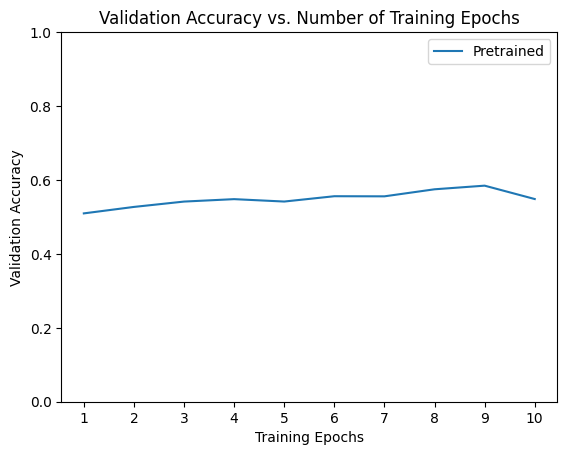

In [27]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs
ohist = []

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()


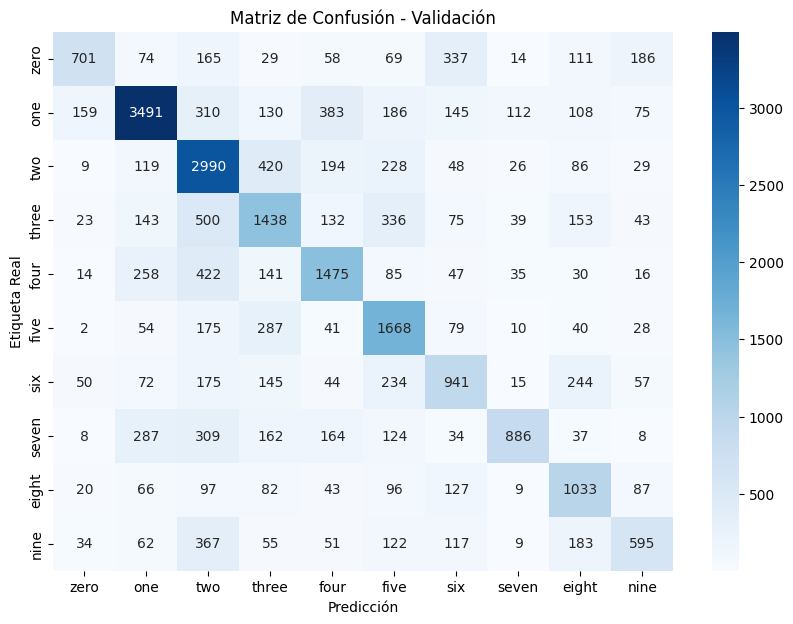

In [29]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

#modo de evaluacion
model_ft.eval()

with torch.no_grad():
    for inputs, labels in dataloaders_dict['val']:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)  # Obtenemos la clase con mayor probabilidad

        all_preds.extend(preds.cpu().numpy())  #  predicciones
        all_labels.extend(labels.cpu().numpy())  # etiquetas reales

# Generar matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión - Validación")
plt.show()

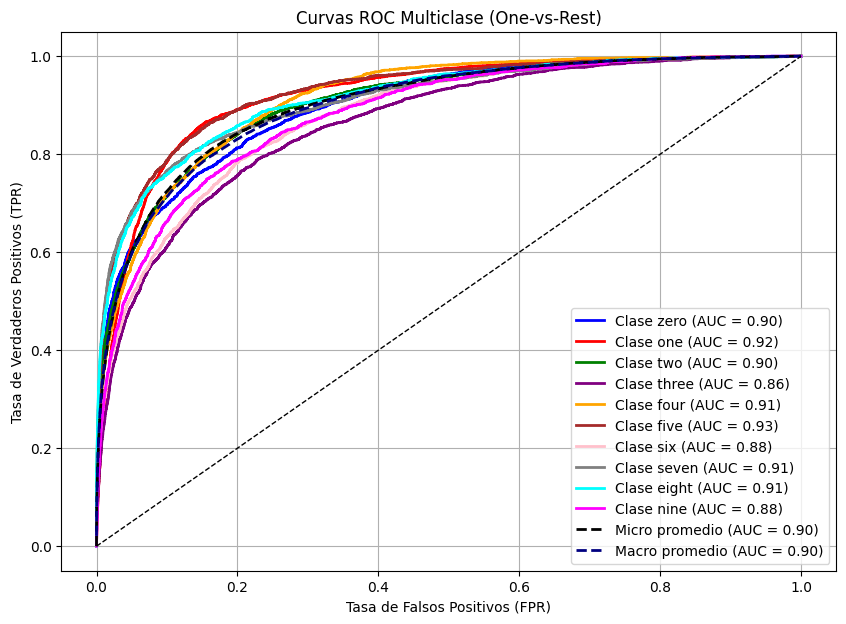

In [32]:
#opcional 1 ROC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

all_labels = []
all_probs = []

# Poner el modelo en modo evaluación
model_ft.eval()

with torch.no_grad():
    for inputs, labels in dataloaders_dict['val']:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_ft(inputs)
        probs = torch.softmax(outputs, dim=1)  # Convertir a probabilidades

        all_labels.extend(labels.cpu().numpy())  # Etiquetas reales
        all_probs.extend(probs.cpu().numpy())  # Probabilidades por clase

# Convertir etiquetas reales a formato binario (One-vs-Rest)
y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))
y_scores = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()

# curva ROC para cada una de las clases
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-promedio
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-promedio
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 7))

# curvas ROC por clase
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

#curvas ROC micro y macro
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro promedio (AUC = {roc_auc["micro"]:.2f})',
         color='black', linestyle='dashed', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro promedio (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle='dashed', linewidth=2)


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC Multiclase (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [42]:
def evaluate_model(model, dataloader, model_name):
    model.eval()  # Modo evaluación
    y_true, y_pred = [], []

    with torch.no_grad():  # No calcular gradientes
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Crear matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    return cm

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/4
----------
train Loss: 2.1199 Acc: 0.2720
val Loss: 1.9103 Acc: 0.3423

Epoch 1/4
----------
train Loss: 2.0683 Acc: 0.2978
val Loss: 1.9284 Acc: 0.3326

Epoch 2/4
----------
train Loss: 2.0550 Acc: 0.3015
val Loss: 1.8999 Acc: 0.3448

Epoch 3/4
----------
train Loss: 2.0592 Acc: 0.3017
val Loss: 1.8516 Acc: 0.3609

Epoch 4/4
----------
train Loss: 2.0692 Acc: 0.2996
val Loss: 1.9106 Acc: 0.3414

Training complete in 16m 6s
Best val Acc: 0.360864


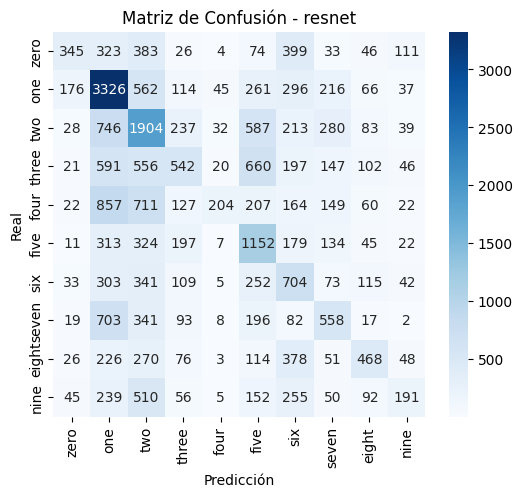

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 164MB/s]


Params to learn:
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/4
----------
train Loss: 2.4103 Acc: 0.2645
val Loss: 2.0278 Acc: 0.3558

Epoch 1/4
----------
train Loss: 2.4061 Acc: 0.2833
val Loss: 1.9618 Acc: 0.3953

Epoch 2/4
----------
train Loss: 2.4113 Acc: 0.2866
val Loss: 2.2163 Acc: 0.2832

Epoch 3/4
----------
train Loss: 2.4117 Acc: 0.2893
val Loss: 2.0102 Acc: 0.3553

Epoch 4/4
----------
train Loss: 2.3948 Acc: 0.2912
val Loss: 2.1011 Acc: 0.3659

Training complete in 14m 10s
Best val Acc: 0.395283


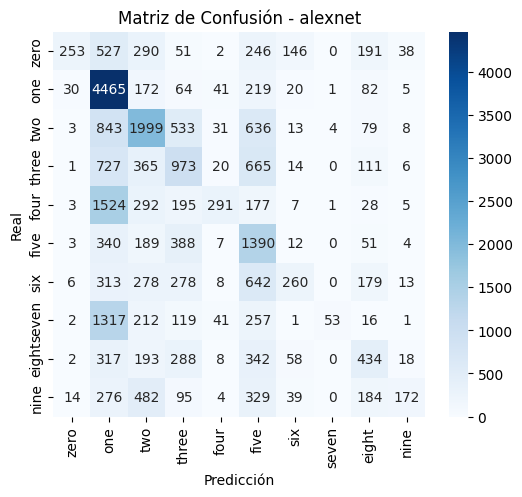

In [43]:
#Tarea opcional 3

model_names = ["resnet", "alexnet"]  #los modelos a probar
for model_name in model_names:
  model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
  model_ft = model_ft.to(device)

  params_to_update = model_ft.parameters()
  print("Params to learn:")
  if feature_extract:
      params_to_update = []
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
  else:
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

  optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
  cm = evaluate_model(model_ft, dataloaders_dict['val'], model_name)

  #  matriz de confusión
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicción")
  plt.ylabel("Real")
  plt.title(f"Matriz de Confusión - {model_name}")
  plt.show()

In [44]:
#Como podemos observar los valores de estas matrices de confusion varian levemente
#pero la concentracion de los valores mas altos y mas bajos coinciden practicamente, por lo que son muy semejantes

In [45]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/ColabNotebooks/Ejercicio_finetuning.ipynb"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/ColabNotebooks/Ejercicio_finetuning.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent t